# Beamline 8.3.2 Reconstruction

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
#import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_helper as als
import util
use_gpu = als.check_for_gpu()
layout = widgets.Layout(width='auto', height='40px')

astropy module not found


Nvidia GPU detected, will use to reconstruct!


### Choose Data

In [2]:
dataDir = "/pscratch/sd/l/lgupta/tomo_recon_saves/originaldata/" # where is the raw data
filelist, names = als.get_directory_filelist(dataDir)
file_choice = als.make_file_selector(filelist, names, dataDir)
widgets.Box([widgets.Label(value='Make a File Selection'), file_choice])
display(file_choice)

interactive(children=(Select(description='files', layout=Layout(width='max-content'), options=('22: 20211222_1…

### Find Center of Rotation (COR)
##### Try many CORs to find best one. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize

In [3]:
all_parameter_widgets = util.get_options(file_choice)
widgets.VBox(all_parameter_widgets)


In [8]:
settings = {
    "path": file_choice.result[0], 
    "angles_ind": all_parameter_widgets[1].result, 
    "slices_ind": all_parameter_widgets[2].result,
    "downsample_factor": all_parameter_widgets[3].result,
    "cor_search_range": all_parameter_widgets[4].result, 
    "cor_search_step": all_parameter_widgets[5].result, 
    "fc": all_parameter_widgets[6].result, 
    "use_gpu": use_gpu
}

interactive(children=(IntSlider(value=20, description='COR', layout=Layout(width='50%'), max=39, readout=False…

interactive(children=(FloatRangeSlider(value=(-0.0035551309585571287, 0.003891887397039681), description='Colo…

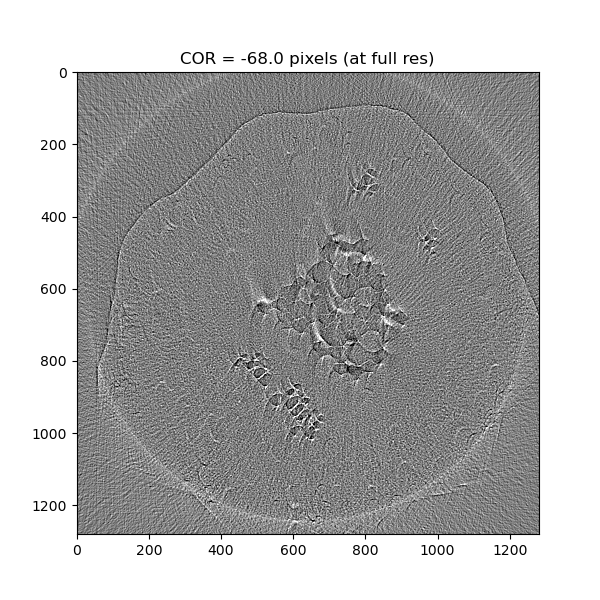

In [15]:
recons, cors = als.basic_reconstructions(**settings)
img, axs, clim_slider = als.plot_recon(recons[0],fignum=1,figsize=6)

cor_slider = widgets.interactive(als.set_cor, i=IntSlider(description='COR', layout=widgets.Layout(width='50%'),
                                                          min=0, max=len(cors)-1, step=1, value=len(cors)//2, readout=False),
                                 img=fixed(img), axs=fixed(axs), recons=fixed(recons), cors=fixed(cors))
display(cor_slider)
display(clim_slider)

##### Check COR by manually aligning 0 and 180 degree projections
###### not doing anything with y shift at the moment

Output()

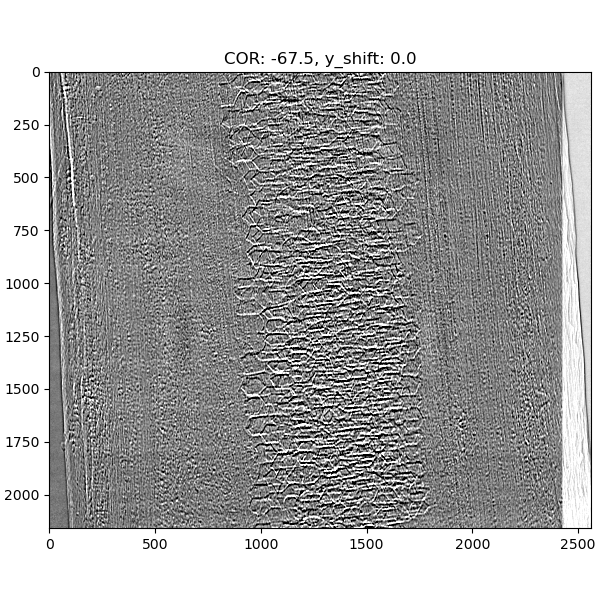

In [19]:
COR = cors[cor_slider.children[0].value]
metadata = als.read_metadata(file_choice.result[0], print_flag = False)
tomo, _ = als.read_data(file_choice.result[0], proj=slice(0,None,metadata['numangles']-1), downsample_factor=None)
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])
axs, img, ui, proj_0_180_sliders = als.plot_0_and_180_proj_diff(first_proj,last_proj_flipped,init_cor=-2*COR,fignum=1,figsize=6)
display(ui,proj_0_180_sliders)

### Reconstuct 2D slice
##### Reconstruct 2D slice with FBP at full resolution with best COR 
##### At full resolution (1313 ang x 2560 rays), takes ~2 sec/slice with GPU, ~30 sec/slice on CPU. Downsampling by 2x reduces time by ~4x (plus loading time)

In [22]:
# settings = {
#     "path": file_choice.result[0], 
#     "angles_ind": all_parameter_widgets[1].result, 
#     "slices_ind": all_parameter_widgets[2].result,
#     "downsample_factor": all_parameter_widgets[3].result,
#     "cor_search_range": all_parameter_widgets[4].result, 
#     "cor_search_step": all_parameter_widgets[5].result, 
#     "fc": all_parameter_widgets[6].result, 
#     "use_gpu": use_gpu
# }

# recons, cors = basic_reconstructions(**settings)
# img, axs, clim_slider = als.plot_recon(recons[0],fignum=1,figsize=6)
# cor_slider = widgets.interactive(als.set_cor, i=IntSlider(min=0, max=len(cors)-1, step=1, value=len(cors)//2), img=fixed(img), axs=fixed(axs), recons=fixed(recons), cors=fixed(cors))
# display(cor_slider)
# display(clim_slider)




##### Remove artifacts with additional sinogram preprocessing and compare to original
##### Preprocessing takes time, reduces resolution, and sometimes can introduce artifacts too, so don't use unless you see significant artifacts in first recon

CPU times: user 299 ms, sys: 3.28 s, total: 3.58 s
Wall time: 3.36 s


(array([<AxesSubplot:title={'center':'No Proprocessing'}>,
        <AxesSubplot:title={'center':'Preprocessing'}>], dtype=object),
  <matplotlib.image.AxesImage at 0x7f55dc129790>])

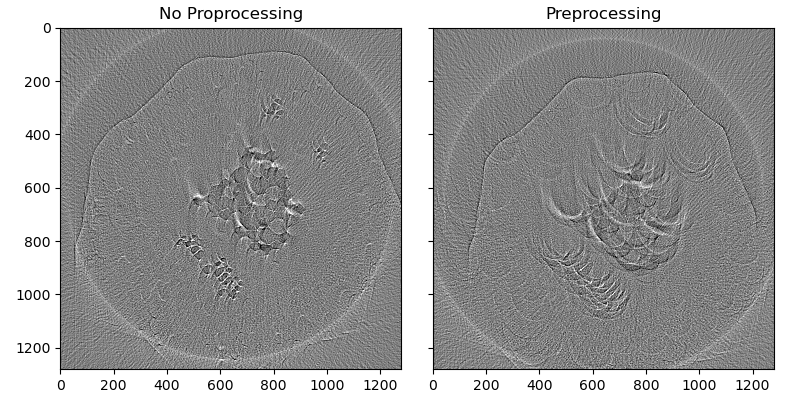

In [30]:
%%time
########## parameters ##########
minimum_transmission= None # threshold for pre-log, normalized sinogram. None turns off
snr = 1  # Sensitivity of stripe detection method. Smaller is more sensitive. Recommended values: 1.1 -> 3.0.
la_size = 1 # Window size of the median filter to remove large stripes. Larger is stronger but takes longer. Choose odd value, set to 1 to turn off.
sm_size = 1 # Window size of the median filter to remove small stripes. Same advice as above
COR = 86.25
# # for original preprocessing
    # 'outlier_diff1D': 750,
    # 'outlier_size1D': 3,
    # 'ringSigma': 3,
    # 'ringLevel': 8,
    # 'ringWavelet': 'db5',

process_settings = {
    "path": file_choice.result[0], 
    "angles_ind": all_parameter_widgets[1].result, 
    "slices_ind": all_parameter_widgets[2].result,
    "downsample_factor": all_parameter_widgets[3].result, 
    "fc": all_parameter_widgets[6].result, 
    "use_gpu": use_gpu,
    "minimum_transmission": minimum_transmission,
    "snr": snr, 
    "la_size": la_size,
    "sm_size": sm_size,
    "COR": COR
}

process_recon = als.reconstruction_with_process(**process_settings)

als.plot_recon_comparison(recons[0], process_recon, titles=['No Proprocessing','Preprocessing'], fignum=4, figsize=4)


### Reconstruct 3D volume
##### At full resolution (1313 ang x 2560 rays), 100 slices takes ~ 30 sec with 1 GPU
##### IF YOU LIKED PREPROCESSING RESULTS: be sure to add relevent lines below
##### For viewing

In [ ]:
%%time
########## parameters (assumes others have ben set above) ##########
slices_ind = slice(1000,1100,1)
settings["slices_ind"] = slices_ind
########## dont touch code below ##########
tomo, angles = als.read_data(settings["path"], sino=settings["slices_ind"], downsample_factor=settings["downsample_factor"])
print(f"Projection data shape: {tomo.shape}")
recon = als.astra_fbp_recon(tomo,angles,center=COR/settings["downsample_factor"],fc=settings["fc"],gpu=settings["use_gpu"])
print(f"Finished reconstruction, size: {recon.shape}")
img, axs = als.plot_recon(recon,fignum=5,figsize=6,clims=[np.percentile(recon,1),np.percentile(recon,99)])
slice_slider = widgets.interactive(als.set_slice, slice_num=IntSlider(min=0, max=len(recon)-1, step=1, value=len(recon)//2),
                                   img=fixed(img), axs=fixed(axs), recon=fixed(recon), slices=fixed(np.arange(slices_ind.start,slices_ind.stop)))
display(slice_slider)
print('')
print('This took:')

##### For saving

In [ ]:
########## parameters (assumes others have ben set above) ##########
outputDir = "/pscratch/sd/d/dperl/tomo_data/Petiole" # somewhere you can write lots of data
subdirectoryname = 'petiole_reconstructions_examples' # new folder where reconstuctions will be saved
start = 0
stop = 500
nchunk = 100
########## dont touch code below ##########
saveDir = os.path.join(outputDir,subdirectoryname,os.path.splitext(filename)[0])
if not os.path.exists(saveDir): os.makedirs(saveDir)
saveName = os.path.join(saveDir,"img")
for i in range(np.ceil((stop-start)/nchunk).astype(int)):
    start_iter = start+i*nchunk
    stop_iter = np.minimum((i+1)*nchunk,stop)
    tomo, angles = als.read_data(path, sino=slice(start_iter,stop_iter,1))
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()
    recon = als.astra_fbp_recon(tomo,angles,center=COR/downsample_factor,fc=fc,gpu=use_gpu)
    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=saveName, start=start_iter)

In [ ]:
# plotting in separate cell, since svmbir takes awhile 
als.plot_recon_comparison(fbp_recon,svmbir_recon,titles=['FBP','SVMBIR'],fignum=6,figsize=4)